# CAFEH Demo

Here we simulate some data and show how to use CAFEH to perform multi-trait fine-mapping and colocalization using individual level data or summary statistics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from cafeh.cafeh_summary import fit_cafeh_summary, fit_cafeh_z
from cafeh.cafeh_genotype import fit_cafeh_genotype

from cafeh.model_queries import *

## Set-up

### Simulate some data

First we simulate some data. We generate 3 phenotypes that all have a distinct causal variant, and a fourth causal variant shared across the 4

We generate multivariate normal "genotype" data where SNPs are correlated with their neighbors in an exponentially decaying manner.

In [2]:
np.random.seed(1)

t = 3  # number of phenotypes
n = 500  # number of samples
p = 1000  # number of features (SNPs)

# simulate some correlated features X
mix = np.exp(-np.abs(np.arange(p) - np.arange(p)[:, None])/50)
X = (np.random.normal(size=(n, p)) @ mix).T

# simulate phenotypes: each with a distinct causal variant and all with a shared causal variant
causal = np.zeros((t, p))
causal[0, [100, 500]] = 1
causal[1, [150, 500]] = 1
causal[2, [200, 500]] = 1

y = causal @ X + np.random.normal(size=(t, n)) * 3

### Compute summary statistics

Next we compute effect sizes and standard errors to use in the summary stat version of CAFEH

In [3]:
y_centered = y - y.mean(1)[:, None]
X_centered = X - X.mean(1)[:, None]

d = np.diag(X_centered @ X_centered.T)
B = (y_centered @ X_centered.T) / d[None]

sq_error = np.array([((y_centered[i][:, None] - X_centered.T * B[i])**2).sum(0) for i in range(t)])
stderr = np.sqrt(sq_error / (n-1) / d[None])
S = np.sqrt(B**2/n + stderr**2)
LD = np.corrcoef(X)

Text(0.5, 1.0, 'Simulation LD Matrix')

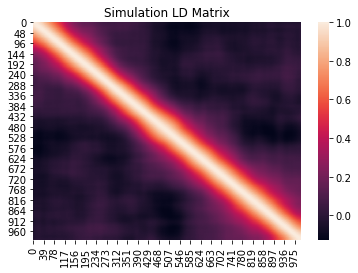

In [4]:
sns.heatmap(np.corrcoef(X))
plt.title('Simulation LD Matrix')

In [5]:
snp_ids = ['snp{}'.format(i) for i in range(p)]
sample_ids = ['sample{}'.format(i) for i in range(n)]
study_ids = ['study{}'.format(i) for i in range(t)]
covariate_ids = ['cov{}'.format(i) for i in range(5)]

In [6]:
# generate some dummy covariates
cov_df = pd.concat({t: pd.DataFrame(np.random.normal(size=(5, n)),
                                    index=covariate_ids, columns=sample_ids) for t in study_ids})

In [7]:
X_df = pd.DataFrame(X, index=snp_ids, columns=sample_ids)
y_df = pd.DataFrame(y, index=study_ids, columns=sample_ids)
LD_df = pd.DataFrame(LD, index=snp_ids, columns=snp_ids)
beta_df = pd.DataFrame(B, index=study_ids, columns=snp_ids)
stderr_df = pd.DataFrame(stderr, index=study_ids, columns=snp_ids)
z_df = pd.DataFrame(B/stderr, index=study_ids, columns=snp_ids)
n_df = pd.DataFrame(np.ones_like(B) * n, index=study_ids, columns=snp_ids)

X_df.to_csv('../example/X_example.tsv', sep='\t')
y_df.to_csv('../example/y_example.tsv', sep = '\t')
cov_df.to_csv('../example/cov_example.tsv', sep='\t')
LD_df.to_csv('../example/LD_example.tsv', sep='\t')
n_df.to_csv('../example/n_example.tsv', sep='\t')
beta_df.to_csv('../example/beta_example.tsv', sep='\t')
stderr_df.to_csv('../example/stderr_example.tsv', sep='\t')
z_df.to_csv('../example/z_example.tsv', sep='\t')


## Fitting CAFEH

We provide routines for fitting CAFEH using either individual level data or summary stats. We offer 3 routines, `fit_cafeh_genotype`, `fit_cafeh_summary` and `fit_cafeh_z` to make the process simple.

### Fit model with `fit_cafeh_genotype`

The individual level version of CAFEH is implimented in `CAFEHGenotype`. `fit_cafeh_genotype` is a routine for initializing and fitting the model. `fit_cafeh_genotype` that accepts the following inputs

You will need

- `X` an $p \times n$ genotype matrix
- `Y` a $t \times n$ phenotype matrix
- `cov` (optional) DataFrame of covariatiats.
- `init_args` (optional) a dictionary of keyword arguments to pass to `CAFEHGenotype` during initialization. Use this to set priors
    -`p0k`: (default `0.1`), the prior probability that a component is active in a tission
    -`prior_variance`: (default `0.1`), the initial variance of effect sizes. This is relative to the phenotypic variance. That is,
- `fit_args` (optional) a dictionary of arguments to pass to the `weight_ard_active_fit_procedure`, you can use this to set the maximum number of iterations `max_iter`, or specify which parameters/variational parameters to update 


**A note on covariates** 

Please note that if you are using covariates the covariates should be formatted as a `pandas.DataFrame` with a 2-level index `[study_id, covariate_name]` and column names that correspond with `sample_ids`. Additionally, you must also specify `sample_ids`, `snp_ids`, and `study_ids`, to `init_args` so that CAFEH knows which covariates apply to each sample.

`labels = {'sample_ids': sample_ids, 'snp_ids':snp_ids', 'study_ids':study_ids}`
`model = CAFEHGenotype(X, y, K=10, init_args=labels)`


**Fitting procedure `weight_ard_active_fit_procedure`** 

In the `fit_` routines we fit the model using `weight_ard_active_fit_procedure`. CAFEH's likelihood is non-convex, we find this procedure avoids local optima during model fitting, and generally leads to acceptable results. We fit the model in 3 stages.

1. Fit the weights holding estimating prior variance and assignments fixed
2. Fit the weights + weight variances holding assignments fixed
3. Fit all parameters in the model

In [8]:
%%time
cafehg = fit_cafeh_genotype(X_df, y_df, covariates=cov_df, K=10)

CPU times: user 4.62 s, sys: 61.5 ms, total: 4.68 s
Wall time: 1.18 s


In the next cell we use `plot_components()` to visualize cafeh's output.
- The right most plot is a heatmap of `cafehg.active` which stores the posterior probability that each component is active in each phenotype.
- The middle plot gives the posterior mean of effects for each component in each phenotype. $\mathbb E[w_{tk}] = \sum_{i=1}^N \pi_{ki} \mathbb E [w_{tki}]$. Where $\pi_{ki}$ is the posterior probability that SNP $i$ is the causal SNP for component $k$ and $w_{tki}$ is the posterior mean of component $k$ and study $i$ conditioned on $i$ being the causal SNP.
- The left plot shows $95\%$ credible sets for each active component (component with posterior probability $>0.5$ for at least one phenotype). x-axis is index of the SNP, y-axis is the posterior probability of the SNP being causal in a component, the component is indicated by color.


We can see that CAFEH correctly identifies the causal variants in our simulation, as well as the pattern of sharing across the phenotypes (one shared across all three phenotypes, and phenotype specific components). The credible sets contain the correct causal variant.

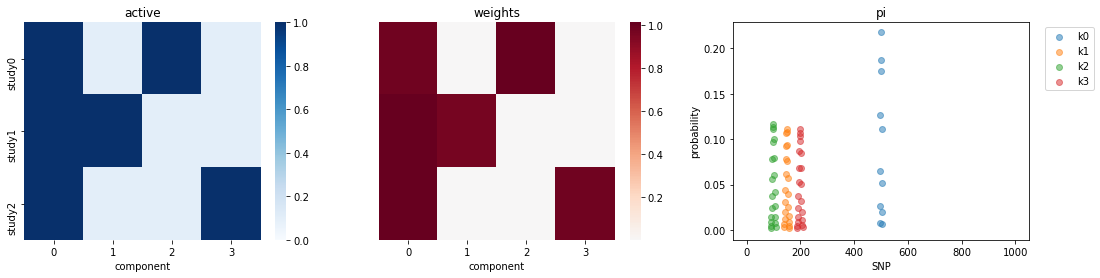

In [9]:
# plot
cafehg.plot_components()

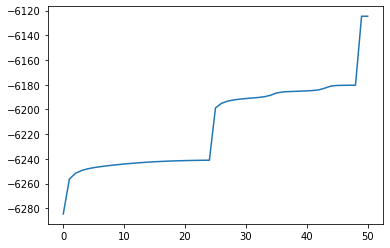

In [10]:
# check ELBO is monotonically increasing
# note that 3 "bumps" are the 3 different stages of model fitting
plt.plot(cafehg.elbos)

In [11]:
# Get 95% Credible sets for each component
# the true causal SNPS (500, 150, 100, 200) each appear in one of the credible sets
credible_sets = cafehg.get_credible_sets(0.95)
credible_sets[0], credible_sets[1], credible_sets[2], credible_sets[3]

(array([500, 499, 501, 498, 502, 497, 503, 496]),
 array([149, 150, 148, 151, 147, 146, 152, 145, 153, 144, 154, 143, 155,
        142, 156]),
 array([ 99, 100,  98, 101,  97, 102,  96, 103,  95, 104,  94, 105,  93,
        106]),
 array([198, 199, 197, 200, 196, 201, 195, 202, 194, 203, 193, 204, 192,
        205, 191]))

In [12]:
# summarize results in a table
variant_report = summary_table(cafehg, filter_variants=True, max_snps=500, min_p_active=0.5)
variant_report.sort_values('alpha').head(n=6)

,variant_id,study,pip,top_component,alpha,rank,p_active,pi,effect,effect_var
99,snp99,study0,0.117023,2,0.0,0,1.0,0.116504,1.015215,0.004046
1149,snp149,study1,0.111771,1,0.0,0,1.0,0.111252,0.968788,0.004293
2198,snp198,study2,0.111454,3,0.0,0,1.0,0.110930,0.990332,0.004386
1500,snp500,study1,0.218130,0,0.0,0,1.0,0.217674,1.011105,0.003826
500,snp500,study0,0.218134,0,0.0,0,1.0,0.217674,0.986057,0.003847
2500,snp500,study2,0.218135,0,0.0,0,1.0,0.217674,1.013115,0.003927


### Saving the model

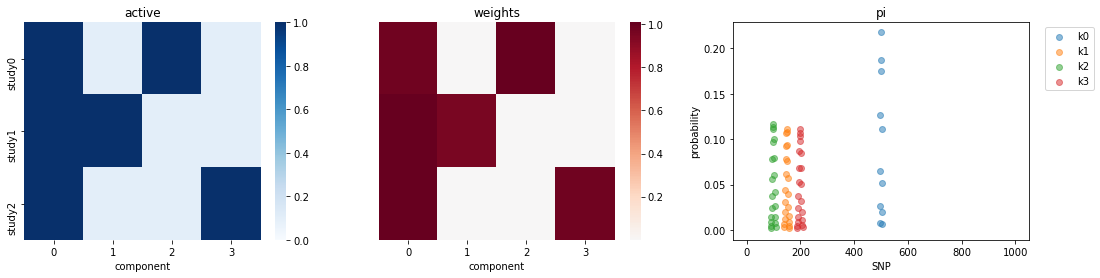

In [13]:
# save model
# by default we do not save the data with the model, if you want the data set save_data=True
cafehg.save('./saved_model.pkl', save_data=True)

# load model
# we save a compact version of the model, when you load the model call _decompress_model()

import pickle
cafehg_reload = pickle.load(open('saved_model.pkl', 'rb'))
cafehg_reload._decompress_model()
cafehg_reload.plot_components()

### Alternative fit procedures

If you would like to try something else, `CAFEHGenotype` and `CAFEHSummary` both impliment a `fit` method that allows you to toggle updates for all of the models parameters via keyword arguments.

Initialze the model with

`cafehg = CAFEHGenotype(X, y, K=K, **init_args)`

Specify which parameters you want to update

`fit_args = {update_pi=True, update_weights=True, max_iter=10}`

And then fit
`cafehg.fit(**fit_args)`
    

### Fit CAFEH with summary stats (betas + standard errors OR z-scores)

The summary stat version of CAFEH is implimented in `CAFEHSummary`.

If you have effect sizes and standard error you can use `fit_cafeh_summary`.
If you have z-scores you can use `fit_cafeh_z`.

Please note that with `fit_cafeh_z`, the scale of the weights may not be comparable across multiple phenotypes, especially if there were a different number of samples in each phenotype, since z-scores conflate effect size and significance.

Implementation of `CAFEHSummary` is based off of the Regression form Summary Statistics (RSS) likelihood of Zhu and Stephens [1]. We impliment a stochastic optimization routine which at each iteration we sample an active SNP for each component according the to current posterior estimates `pi`.

### Fit with betas and standard errors

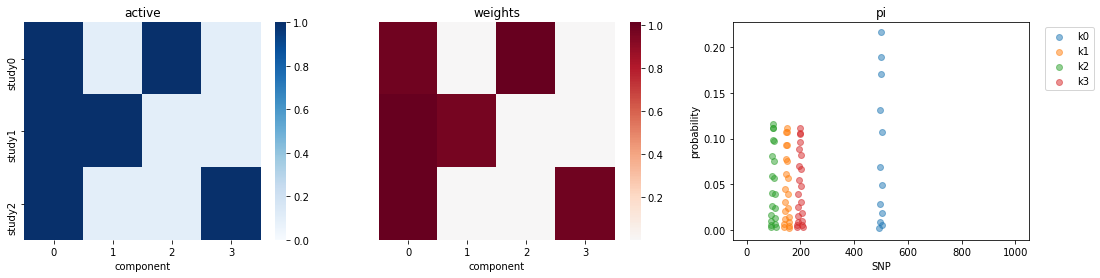

CPU times: user 5.43 s, sys: 101 ms, total: 5.53 s
Wall time: 1.67 s


In [14]:
%%time
cafehs = fit_cafeh_summary(LD_df, beta_df, stderr_df, n=n)
cafehs.plot_components()

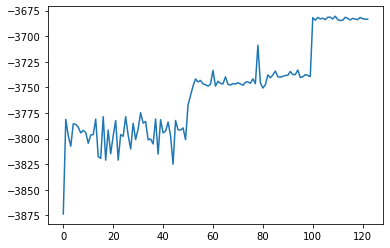

In [15]:
# cafeh_summary utlizes a stochastic optimization procedure.
# we can monitor monte-carlo estimates of the ELBO but
# be aware that we cannot expect them to increase monitonically

plt.plot(cafehs.elbos)

### Fit with z scores

note that the effect sizes should not be interpreted as the magnitude of effect when fitting with z scores.

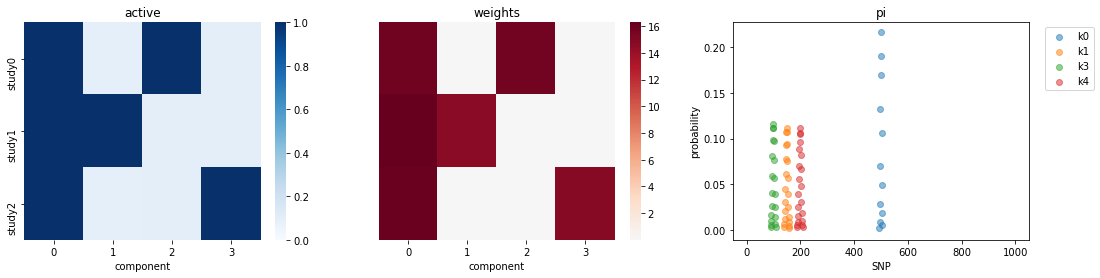

CPU times: user 8.08 s, sys: 98.7 ms, total: 8.18 s
Wall time: 2.31 s


In [16]:
%%time
cafehs = fit_cafeh_z(LD_df, z_df, n=n_df)
cafehs.plot_components()

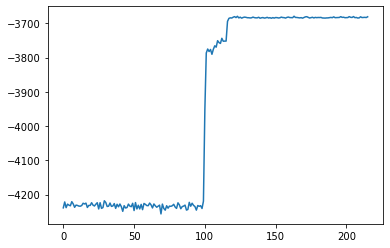

In [17]:
# cafeh_summary utlizes a stochastic optimization procedure.
# we can monitor monte-carlo estimates of the ELBO but
# be aware that we cannot expect them to increase monitonically

plt.plot(cafehs.elbos)

### References 

1. Zhu, X., & Stephens, M. (2017). Bayesian large-scale multiple regression with summary statistics from genome-wide association studies. The annals of applied statistics, 11(3), 1561.
